In [14]:
import shap
import pickle
import numpy as np
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       ensure_shap_values_are_3d
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
shap.initjs()
%matplotlib inline
task_name = '01'

In [2]:
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)
with open(task_name + '.expl', 'rb') as f:
    #explanations, _, _ = pickle.load(f)
    explanations = pickle.load(f)

# Local Explanations

Here we will use the explanations obtained globally for the multiclass difference classifier to cluster instances, and inspect the individual classifiers explanations on a local level.

In [3]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff_proba = comparer.predict_mclass_diff_proba(explanations.data)

## Cluster Explanations in an Unsupervised Manner

We will cluster instances, for which the two classifiers have different predictions, with a hierarchical clustering algorithm using squared euclidian distances.

In [4]:
explanations_diff = explanations[is_pred_diff]
shap_values = explanations_diff.mclass_diff.log_odds[:, :, comparer.difference_class_names]
shap_values = ensure_shap_values_are_3d(shap_values)
values = shap_values.values.reshape(
    (shap_values.values.shape[0],
     shap_values.values.shape[1] * shap_values.values.shape[2]))
values = np.concatenate([values], axis=1)
D = sp.spatial.distance.pdist(values, metric='sqeuclidean')
Z = sp.cluster.hierarchy.complete(D)

In the dendrogram we see, that there are basically two bigger clusters that can be investigated further.

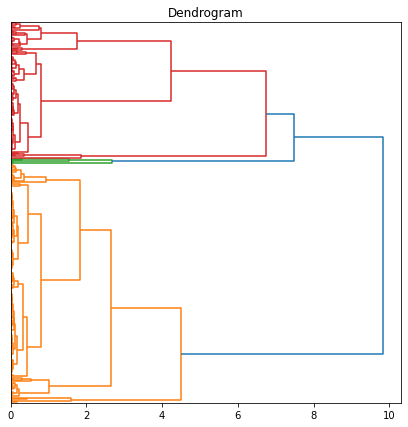

In [8]:
fig, ax = plt.subplots(figsize=(7, 7))
sp.cluster.hierarchy.dendrogram(Z, orientation='right', ax=ax, no_labels=True)
ax.set_title('Dendrogram')
plt.show()

In [9]:
n_clusters = 2
cluster_names = np.array([f'c{idx}' for idx in range(1, n_clusters+1)])
clustering = sp.cluster.hierarchy.fcluster(Z, t=n_clusters, criterion='maxclust')
clustering -= 1

Plotting all instances coloured by clustering, we see that on cluster covers lower Education-Num values, the other higher values.

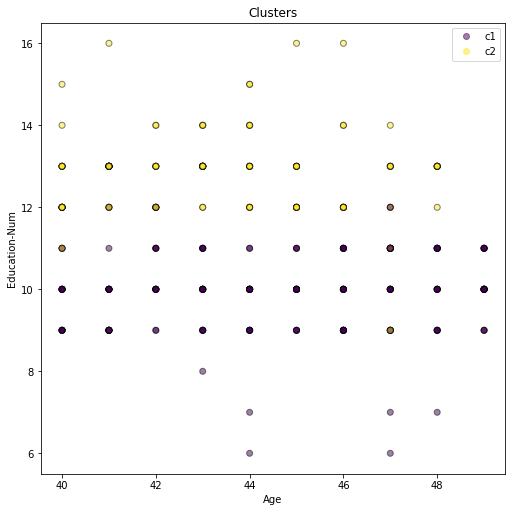

In [11]:
idx_x, idx_y = 0, 2
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
scatter = ax.scatter(explanations_diff.display_data[:, idx_x],
                     explanations_diff.display_data[:, idx_y],
                     c=clustering, alpha=0.5, edgecolors='k')
ax.set_xlabel(explanations_diff.feature_names[idx_x])
ax.set_ylabel(explanations_diff.feature_names[idx_y])
ax.set_title('Clusters')
ax.legend(scatter.legend_elements()[0], cluster_names.tolist());

In [12]:
explanations_clustered = explanations_diff.cohorts(cluster_names[clustering])

We can further analyze the value ranges present in each cluster:

In [44]:
X = pd.DataFrame(explanations.display_data.tolist(), columns=explanations.feature_names)
X_clusters = [pd.DataFrame(display_data.tolist(), columns=explanations.feature_names) for display_data in explanations_clustered.display_data.cohorts.values()]

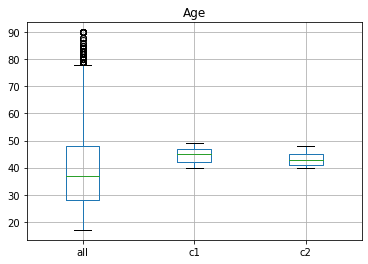

Workclass


,all,c1,c2
Private,0.547619,0.671362,0.547619
Federal-gov,0.103175,0.028169,0.103175
Local-gov,0.103175,0.051643,0.103175
Self-emp-not-inc,0.103175,0.154930,0.103175
State-gov,0.071429,0.018779,0.071429
Self-emp-inc,0.055556,0.056338,0.055556
?,0.015873,0.018779,0.015873


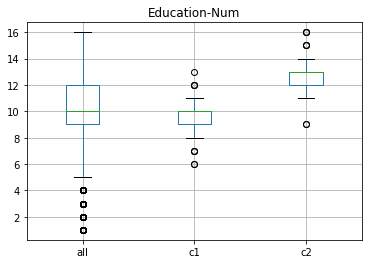

Marital Status


,all,c1,c2
Married-civ-spouse,0.769841,0.971831,0.769841
Divorced,0.190476,0.028169,0.190476
Never-married,0.031746,NaN,0.031746
Widowed,0.007937,NaN,0.007937


Occupation


,all,c1,c2
Exec-managerial,0.246032,0.150235,0.246032
Prof-specialty,0.222222,0.056338,0.222222
Adm-clerical,0.134921,0.046948,0.134921
Tech-support,0.103175,0.023474,0.103175
Craft-repair,0.087302,0.192488,0.087302
Other-service,0.039683,0.037559,0.039683
Sales,0.039683,0.187793,0.039683
Handlers-cleaners,0.031746,0.014085,0.031746
Machine-op-inspct,0.031746,0.065728,0.031746
Protective-serv,0.023810,0.028169,0.023810


Relationship


,all,c1,c2
Husband,0.539683,0.943662,0.539683
Wife,0.222222,0.028169,0.222222
Unmarried,0.095238,0.009390,0.095238
Not-in-family,0.087302,NaN,0.087302
Own-child,0.047619,0.018779,0.047619
Other-relative,0.007937,NaN,0.007937


Race


,all,c1,c2
White,0.714286,0.924883,0.714286
Asian-Pac-Islander,0.174603,0.032864,0.174603
Black,0.079365,0.032864,0.079365
Amer-Indian-Eskimo,0.023810,0.004695,0.023810
Other,0.007937,0.004695,0.007937


Sex


,all,c1,c2
Male,0.714286,0.967136,0.714286
Female,0.285714,0.032864,0.285714


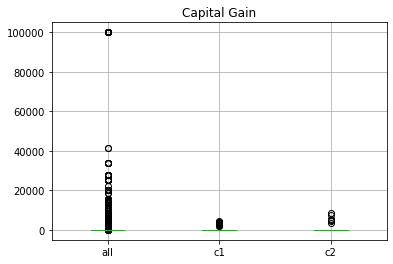

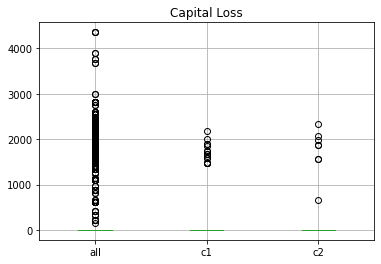

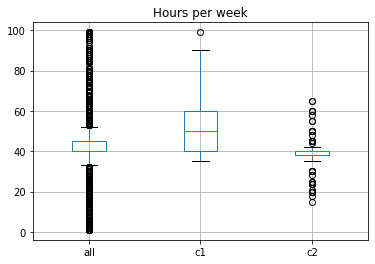

Country


,all,c1,c2
United-States,0.785714,0.934272,0.785714
?,0.071429,0.014085,0.071429
Philippines,0.039683,0.009390,0.039683
Japan,0.031746,0.004695,0.031746
China,0.023810,0.004695,0.023810
India,0.015873,0.004695,0.015873
England,0.007937,NaN,0.007937
Haiti,0.007937,NaN,0.007937
Italy,0.007937,0.004695,0.007937
Vietnam,0.007937,NaN,0.007937


In [118]:
for feature_name in comparer.feature_names:
    if X[feature_name].dtype == float:
        df = pd.concat([X[feature_name]] + [X_cluster[feature_name] for X_cluster in X_clusters], axis=1)
        df.columns = ['all'] + cluster_names.tolist()
        df.boxplot()
        plt.title(feature_name)
        plt.show()
    else:
        s = X_cluster[feature_name]
        d = {'all': s.value_counts() / s.count()}
        for cluster_name, X_cluster in zip(cluster_names, X_clusters):
            s = X_cluster[feature_name]
            d[cluster_name] = s.value_counts() / s.count()
        print(feature_name)
        display(pd.DataFrame(d).sort_values('all', ascending=False))

### Feature Influence

Obtain a feature order, ranked by mean absolute influence on the instances with different predictions:

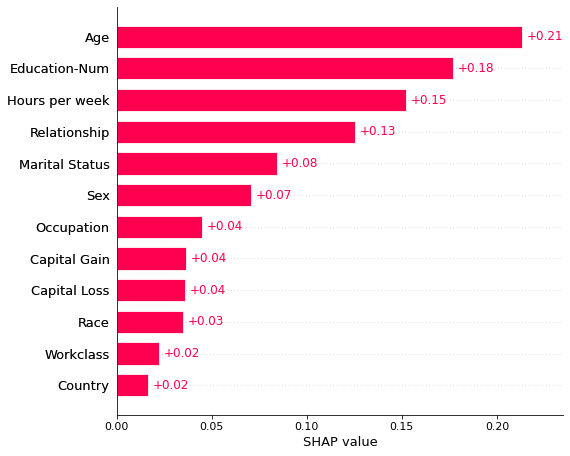

In [52]:
feature_order, feature_importance = calc_feature_order(explanations.bin_diff.labels[is_pred_diff])
plot_feature_importance_bar(feature_importance)

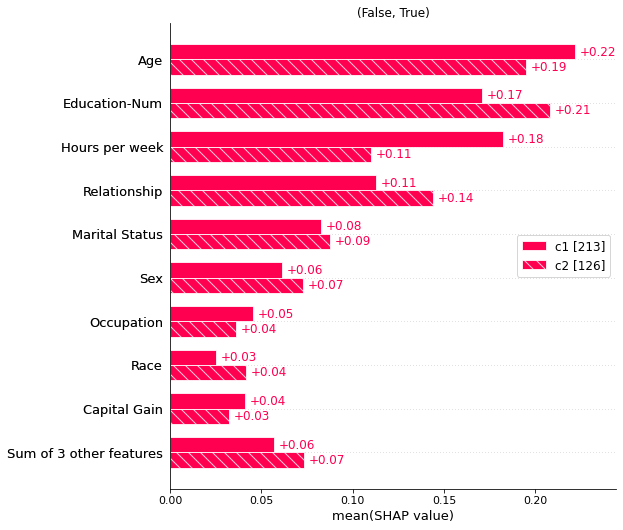

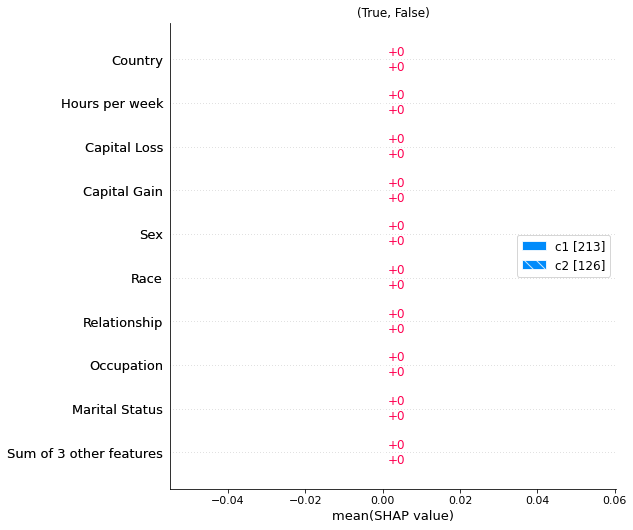

In [54]:
for label in comparer.difference_class_names:
    plt.title(label)
    shap.plots.bar(explanations_clustered.mclass_diff.labels[:, :, label].mean(0))

### Feature Effects

This can be skipped, since the global plots had all the information already.

### Decision Plot

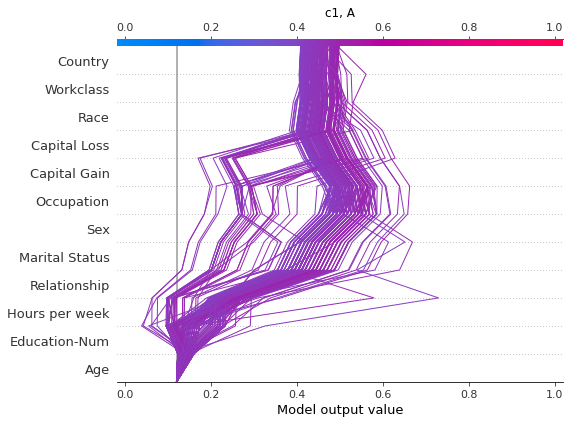

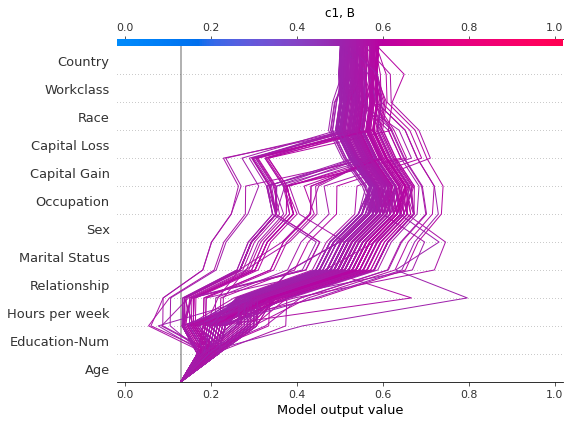

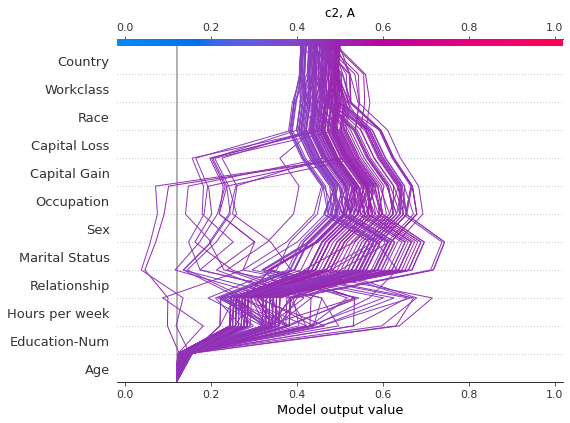

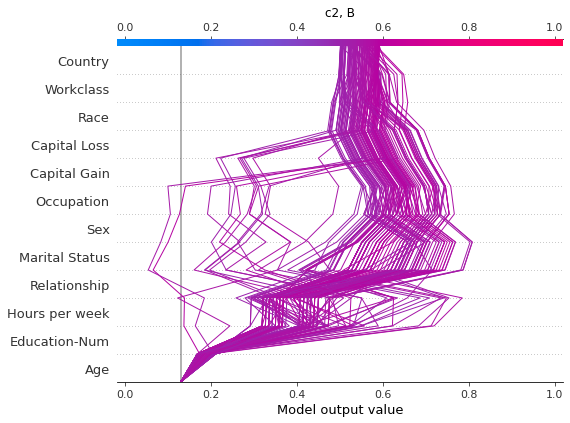

In [55]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
for cluster_name in indiv.A.cohorts.keys():
    for clf_name, shap_values in [('A', indiv.A), ('B', indiv.B)]:
        shap_values = shap_values.cohorts[cluster_name]
        shap.decision_plot(shap_values.base_values[0], shap_values.values, features=shap_values.data,
                           feature_names=shap_values.feature_names, feature_order=feature_order,
                           link='logit', title=f'{cluster_name}, {clf_name}')

### Force Plot

Furthermore we visualize the instances in force plots, ordered by similarity of their multiclass difference classes.

In [56]:
indiv = explanations_clustered.indiv.log_odds[:, :, 1]
for cluster_name in indiv.A.cohorts.keys():
    instance_order = calc_instance_order(
        explanations_clustered.mclass_diff.log_odds[
            :,
            :,
            comparer.difference_class_names
        ].cohorts[cluster_name])
    for clf_name, shap_values in [('A', indiv.A), ('B', indiv.B)]:
        shap_values = shap_values.cohorts[cluster_name]
        plot = shap.plots.force(
            base_value=shap_values.base_values[0],
            shap_values=shap_values.values,
            features=shap_values.data,
            feature_names=shap_values.feature_names,
            out_names=f'{cluster_name}, {clf_name}',
            ordering_keys=instance_order.tolist(),
            link='logit')
        display(plot)